# Text Mining using Dimensionality Reduction Methods


This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have learned can be applied to get a good idea of what our users are expressing.

In [1]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc


# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [18]:
imdb_data = pd.read_excel('IMDB_Sample.xlsx')
print(imdb_data.head())

# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )


# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)
print('\nAs an example')
print('Text: ',x_train.iloc[340])
print('Class: ',y_train.iloc[340])

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

print('\n*****************\nTo see what happens after applying TfIDF')
print(TfIDF_train[340,:])
print('\nThe number of independent variables that texts are analyzed based on:')
print(TfIDF_train.shape[1])


# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

print('\nThe same text as a dense matrix')
print(TfIDF_train[340,:])


                                               texts  class
0  Lars Von Triers Europa is an extremely good fi...      1
1  Emily Watson's Natalia is absolutely the most ...      1
2  Two thirds of nearly 2,000 IMDb users who have...      1
3  This is what I was expecting when star trek DS...      1
4  An ultra-nervous old man, "Mr. Goodrich," terr...      1

As an example
Text:  Rating "10/10" Master pieceSome years ago, i heard Spielberg comment that he would redo the movie here and there if he had a chance. Well, Mr Spielberg, i guess nothing is perfect, but this movie - together with schindler's List - is your best. Even Oprah acts well in this one !What got me most is the realism of the story and drama. Stuff like this happened and is still happening in the world.'
Class:  1

*****************
To see what happens after applying TfIDF
  (0, 234)	0.2995571399523656
  (0, 228)	0.31845387467961445
  (0, 51)	0.3969415589322562
  (0, 111)	0.1939070474462102
  (0, 0)	0.5576500961578521
  

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [40]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


In [94]:
TfIDFTransformer.get_feature_names()[:10]


['10',
 'absolutely',
 'acting',
 'action',
 'actor',
 'actors',
 'actress',
 'actually',
 'age',
 'amazing']

## Task 1: PCA decomposition of the texts

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

,Explained_var
Component,
1,0.019683
2,0.015244
3,0.013678
4,0.013156
5,0.012507
...,...
232,0.000793
233,0.000770
234,0.000735


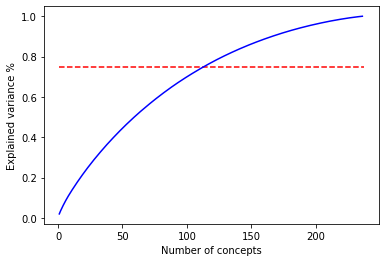

In [56]:

PCA_IMDB = PCA(n_components = 236)
PCA_IMDB.fit(TfIDF_train)
PCA_variances = PCA_IMDB.explained_variance_ratio_


DF = (pd.DataFrame({'Component':[i for i in range(1,237)],
                    'Explained_var': PCA_variances.round(6)}).set_index('Component'))

display(DF)

### Make the plot
    
plt.plot(np.arange(1, 237), np.cumsum(PCA_variances), 'b')
plt.hlines(0.75, xmin=1, xmax=237, colors='r', ls='dashed')
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')
plt.show()
    

In [25]:
# To get the exact index where the variance is above 75%
for j in range(len(Cum_variance)):
    if Cum_variance[j] > 0.75:
        print(f'The min number of concepts to correctly explain at least 75% of data is: {j} ')
        break
        
np.argwhere(np.cumsum(PCA_1.explained_variance_ratio_)>0.75).min()



The min number of concepts to correctly explain at least 75% of data is: 113 


113

**Written answer:** We need at least 113 parameters to accurately predict 75% of the data.

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [58]:
# Explained variance.
print('The first three components explain %.2f%% of the variance' % (np.cumsum(PCA_variances)[2] * 100))

The first three components explain 4.86% of the variance


In [63]:
# Get words per component
words_per_row = TfIDFTransformer.get_feature_names()

most_important = [np.argpartition(np.abs(PCA_IMDB.components_[i]), -10)[-10:] for i in range(3)]

In [64]:
# Concept 1
[words_per_row[i] for i in most_important[0]]


['don',
 'best',
 'woman',
 'films',
 'like',
 'movies',
 'film',
 'bad',
 'watch',
 'movie']

In [65]:
# Concept 2
[words_per_row[i] for i in most_important[1]]

['say',
 'love',
 'films',
 'film',
 'like',
 'great',
 'way',
 'series',
 'story',
 'bad']

In [66]:
# Concept 3
[words_per_row[i] for i in most_important[2]]

['new',
 'acting',
 'old',
 'seen',
 'funny',
 'star',
 'man',
 'series',
 'movie',
 'film']

In [43]:
acc_var = 0
for j in range(1,4):
    acc_var += DF.Explained_var[j]  
    
print(f"The cumulative variance for the first three components is : {round(acc_var,6)}")

The cumulative variance for the first three components is : 0.048605


**answer:** 
 There are several interpretations that can be done here, but in general we can say that the first component identifies movies with generally an `intense sentiment` ("best", "like", "bad", etc.), the second one could be `movies with a story` (good and bad ones) and the third one `hints at comedies`.

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

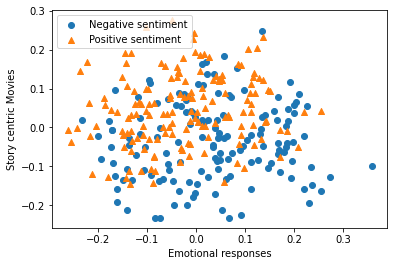

In [73]:
# Apply the test data
test_pca = PCA_IMDB.transform(TfIDF_test)

# Plot the two different set of points filtering by label.

fig = plt.figure()
ax = fig.add_subplot(111)



ax.scatter(test_pca[:,0][y_test == 0], test_pca[:,1][y_test == 0],\
           marker='o', label='Negative sentiment')
ax.scatter(test_pca[:,0][y_test == 1], test_pca[:,1][y_test == 1],\
           marker='^', label='Positive sentiment')

ax.set_xlabel('Emotional responses')
ax.set_ylabel('Story centric Movies')
plt.legend()
plt.show()

**answer:** 
While the two components do not explain too much variance, there are two clear accumulation points. Several movies that are story-centric with a relatively low emotional response are characterized as good, while movies with little story and strong emotional response are poorly classified.

## Task 2: Autoencoders

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer, to be trained over the original TfIDF train dataset. Use a total of 5 fully connected layers going from 236 to 100 to 60 to 100 to 236 units. Use a relu non-linearity for each of them. Plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?**

In [74]:
# Model architecture and definition
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,100),
            nn.ReLU(inplace =True),
            nn.Linear(100,60),
            nn.ReLU(inplace =True),
            )
        self.decoder = nn.Sequential(
            nn.Linear(60,100),
            nn.ReLU(inplace =True),
            nn.Linear(100,236),
            nn.ReLU(inplace =True),
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [75]:
#build model
auto_enc = autoencoder()

#define loss function
loss_fn = torch.nn.MSELoss()

#define learning rate
learning_rate = 1e-1

#convert dataset to tensors
x_train_tensor = torch.from_numpy(TfIDF_train).float()
x_test_tensor = torch.from_numpy(TfIDF_test).float()


##train model
loss_per_batch_train = []
loss_per_batch_test = []

for t in range(5000):
    train_aut = auto_enc(x_train_tensor)
    loss = loss_fn(x_train_tensor, train_aut)      # what we get from autoencoder is X^
    if t % 100 == 99:
        test_aut = auto_enc(x_test_tensor)
        loss_test = loss_fn(x_test_tensor, test_aut)
        loss_per_batch_test.append(loss_test.item())
        loss_per_batch_train.append(loss.item())
    auto_enc.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in auto_enc.parameters():
            param -= learning_rate * param.grad 


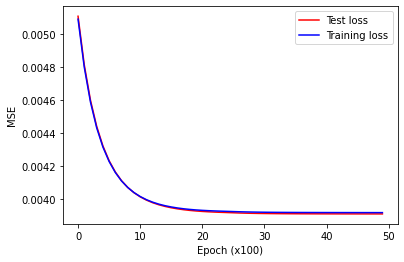

In [77]:
# Plot errors

plt.plot(loss_per_batch_test, 'r', label='Test loss')
plt.plot(loss_per_batch_train, 'b', label='Training loss')
plt.xlabel('Epoch (x100)')
plt.ylabel('MSE')
plt.legend()
plt.show()

**answer:** The autoencoder reaches stability after approximately 2000 epochs, and that it performs equivalently for train and test. The model does not overfit, which is to be expected: an autoencoder is simply a compression algorithm, so it always reduces information, thus it cannot overfit as there is no noise that could be learnt (it would always be discarded)

## Task 3: Benchmarking predictive capabilities of the compressed data.

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression) to predict the positive / negative class label for each movie. Calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

/Users/razbeh/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


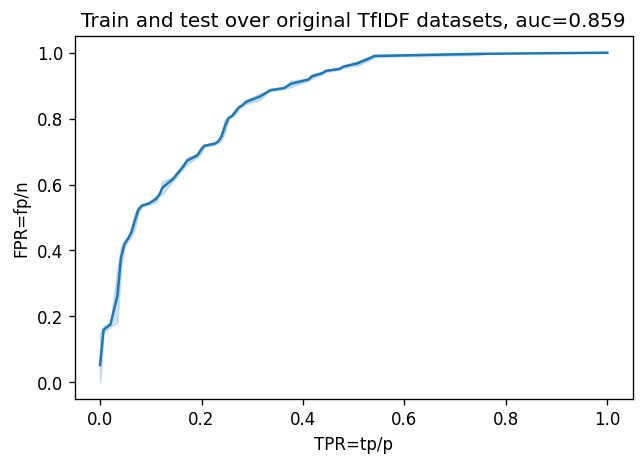

In [89]:
# Full dataset regression and AUC plot / calculation

LogRegFull = LogisticRegressionCV(cv =5, max_iter = 1000, multi_class='auto')

LogRegFull.fit(TfIDF_train, y_train.values.ravel())

y_pred = LogRegFull.predict(TfIDF_test)
y_probs = LogRegFull.predict_proba(TfIDF_test)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)

fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')
plt.title('Train and test over original TfIDF datasets, auc='+str(auroc))
plt.show()

/Users/razbeh/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


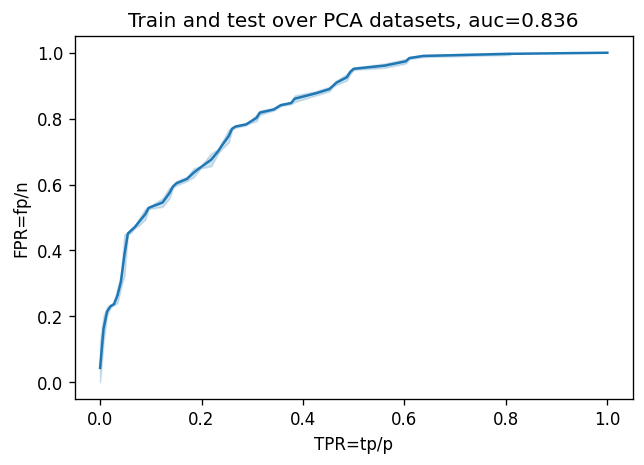

In [90]:
# PCA dataset regression and AUC plot / calculation

PCA_IMDB = PCA(n_components = 60)

x_train_pca = PCA_IMDB.fit_transform(TfIDF_train)
x_test_pca = PCA_IMDB.transform(TfIDF_test)


LogRegPCA = LogisticRegressionCV(cv =5, max_iter = 1000, multi_class='auto')


LogRegPCA.fit(x_train_pca, y_train.values.ravel())

y_pred = LogRegPCA.predict(x_test_pca)
y_probs = LogRegPCA.predict_proba(x_test_pca)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)

fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')

plt.title('Train and test over PCA datasets, auc='+str(auroc))
plt.show()

/Users/razbeh/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


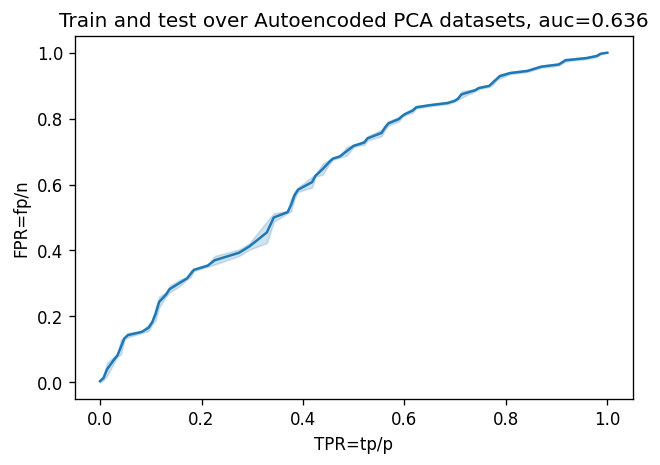

In [93]:
# Autoencoder dataset regression and AUC plot / calculation
x_train_auto = auto_enc.encoder(x_train_tensor).detach().numpy()
x_test_auto = auto_enc.encoder(x_test_tensor).detach().numpy()

LogRegAuto = LogisticRegressionCV(cv =5, max_iter = 1000, multi_class='auto')


LogRegAuto.fit(x_train_auto, y_train.values.ravel())

y_pred = LogRegAuto.predict(x_test_auto)
y_probs = LogRegAuto.predict_proba(x_test_auto)


auroc = np.round(roc_auc_score(y_true = y_test.values.ravel(), 
                             y_score = y_probs[:,1]), decimals = 3)

fpr_t, tpr_t , _ = roc_curve(y_test, y_probs[:,1], pos_label = 1)

fig, ax = plt.subplots(dpi = 120)

ax = sns.lineplot(fpr_t, tpr_t)
plt.xlabel('TPR=tp/p')
plt.ylabel('FPR=fp/n')
plt.title('Train and test over Autoencoded PCA datasets, auc='+str(auroc))
plt.show()

**answer:** We can clearly see the PCA method is superior in keeping the predictive capability intact. The rotation method preserves most of the variance (around 50%), and this variance is related to the sentiment as we saw in task 1.1. The autoencoder, on the other hand, has no guarantees regarding the difference between the original data and the new variables. Besides, it is a non-linear method of compression, so logistic regression might not be the best method to measure its performance. In this case, PCA is clearly the superior alternative